In [22]:
import io
import cv2

import numpy as np
import random 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
from datetime import datetime
# import torch
# import torch.nn as nn
# from torch.autograd import Variable
import matplotlib.pyplot as plt

In [23]:
df = pd.read_csv('data.csv')
df = df.drop(columns=['Open', 'Low', 'High'])
df = df.set_index('Date')
df

,Close,PE_CAPE
Date,,
1960-01-04,59.910000,18.338285
1960-01-05,60.389999,18.338285
1960-01-06,60.130001,18.338285
1960-01-07,59.689999,18.338285
1960-01-08,59.500000,18.338285
...,...,...
2021-12-27,4791.190000,38.660000
2021-12-28,4786.350000,38.660000
2021-12-29,4793.060000,38.660000


In [24]:
date = df.index.to_numpy()
close = df['Close'].to_numpy()
pe = df['PE_CAPE'].to_numpy()
close_lag = []
pe_lag = []
r = []
for i in range(180, len(close)):
    x = close[i-180:i]
    y = pe[i-180:i]
    close_lag.append(x)
    pe_lag.append(y)
    r.append(pearsonr(x, y)[0])
close_lag = np.array(close_lag)
pe_lag = np.array(pe_lag)
r = np.array(r)
close_value = close[180:]
pe_value = pe[180:]

In [25]:
from scipy.signal import argrelextrema
time = ['1960-01-01']
money = [1]
i = 0
while i < len(close_value):
    if r[i] > 0.9 and pe_lag[i,0] < pe_lag[i,-1]:
        buy = close_lag[i, argrelextrema(close_lag[i,:], np.less)[0][0]]
        sell = close_value[i]
        money.append(money[-1] * sell / buy)
        time.append(date[180+i])
        i += 180
    else:
        i += 1

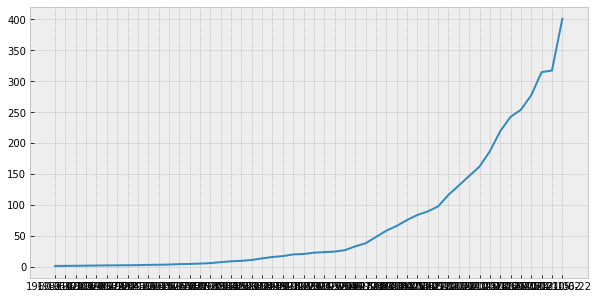

In [26]:
plt.figure(figsize=(10,5))
plt.plot(time, money)

In [27]:
v = 0
prn = set()
while v < len(close_value):
    mini = argrelextrema(close_lag[v,:], np.less)[0]
    maxi = argrelextrema(close_lag[v,:], np.greater)[0]
    i = 0; j = 1; k = 0
    while j < len(maxi) and k < len(mini):
        if mini[k] < maxi[j]:
            k += 1
            continue
        if close_lag[v, maxi[i]] < close_lag[v, maxi[j]] and close_lag[v, maxi[j]] < close_lag[v, maxi[-1]]:
            # diff within 1%
            if abs(close_lag[v, maxi[i]] - close_lag[v, mini[k]]) < 0.01 * close_lag[v, maxi[i]]:
                prn.add(v)
        i += 1
        j += 1
    v += 1

In [28]:
abcd = []
for v in prn:    
    if close_lag[v,-1] == np.max(close_lag[v,:]):
        abcd.append(v)
len(abcd)

1644

In [29]:
oos = list(set([i for i in range(len(close_value))]) - prn)
len(oos)

2135

In [30]:
# def fig2img(fig, dpi=180):
#     buf = io.BytesIO()
#     fig.savefig(buf, format="png", dpi=dpi)
#     buf.seek(0)
#     img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
#     buf.close()
#     img = cv2.imdecode(img_arr, 1)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     img = cv2.resize(img,(50,50),interpolation = cv2.INTER_AREA).astype(np.uint8)

#     return img

# data = []
# plt.figure(figsize=(5,5))
# for i in oos:
#     fig = plt.gcf()
#     plt.plot(range(180), close_lag[i,:])
#     plt.axis('off');
#     data.append(fig2img(fig).flatten())
#     plt.clf()
# for i in abcd:
#     fig = plt.gcf()
#     plt.plot(range(180), close_lag[i,:])
#     plt.axis('off');
#     data.append(fig2img(fig).flatten())
#     plt.clf()
# for i in dcba:
#     fig = plt.gcf()
#     plt.plot(range(180), close_lag[i,:])
#     plt.axis('off');
#     data.append(fig2img(fig).flatten())
#     plt.clf()
# data = np.array(data)
# np.save('data', data)

In [31]:
# labels = np.array([0]*len(oos) + [1]*len(abcd) + [2]*len(dcba))
# np.save('labels', labels)

(3779, 2500) (3779,)


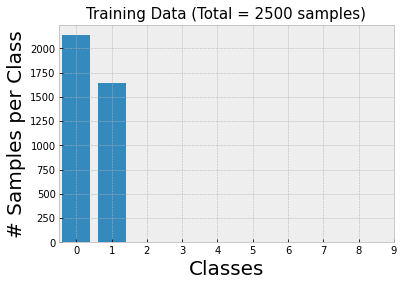

In [32]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Dense, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from tensorflow.keras.layers import BatchNormalization
from numpy import mean, std
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

# Loading Data
data = np.load('data.npy')
labels = np.load('labels.npy')
data_train = data
labels_train = labels
print(data_train.shape, labels_train.shape)

# Counting number samples per class
vals, counts = np.unique(labels_train, return_counts=True)

plt.bar(vals, counts)
plt.xticks(range(10),range(10))
plt.xlabel('Classes',size=20)
plt.ylabel('# Samples per Class', size=20)
plt.title('Training Data (Total = '+str(data_train.shape[1])+' samples)',size=15);

In [33]:
df_test = df['2014-01-01':]
close_test = df_test['Close'].to_numpy()
pe_test = df_test['PE_CAPE'].to_numpy()
cmin = close_test.min()
cmax = close_test.max()
close_test = (close_test - cmin) / (cmax - cmin)
pe_test = (pe_test - pe_test.min()) / (pe_test.max() - pe_test.min())

In [34]:
close_lag_test = []
pe_lag_test = []
for i in range(180, len(close_test)):
    close_lag_test.append(close_test[i-180:i])
    pe_lag_test.append(pe_test[i-180:i])
close_lag_test = np.array(close_lag_test)
pe_lag_test = np.array(pe_lag_test)
close_value_test = close_test[180:]

In [35]:
word_dict = {0:'SEll',1:'HOLD'}
import argparse
import skimage as sk
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from skimage import transform
from skimage import util
from sklearn.preprocessing import StandardScaler, label_binarize
import cv2



# load train and test dataset
def load_dataset():
    # load dataset
    kernel = np.ones((4,4),np.uint8)
    trainX, testX, trainY, testY = train_test_split(data_train, labels_train, test_size = 0.25, stratify=labels_train)
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 50, 50, 1))
    testX = testX.reshape((testX.shape[0], 50, 50, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
#     testY = to_categorical(testY)
    print(trainX.shape, trainY.shape, testX.shape, testY.shape)
    return trainX, trainY, testX, testY
 
# scale pixels
def prep_pixels(data):
    # convert from integers to floats
    data = data.astype('float32')
    # he_uniformize to range 0-1
    data = (255.0 - (data))
    data = data/255.0
    # return he_uniformized images
    return data
 
# define cnn model
def define_model(learn_rate=0.0001, eps=1e-7, dropout_rate=0.5):
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(50, 50, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout_rate))
    model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((4, 4)))
    model.add(Dropout(dropout_rate))
    model.add(Flatten(name='feat_cnn'))
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(2, activation='softmax'))
    # compile model
    opt = Adam(learning_rate=learn_rate , epsilon=eps)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
 
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, tes_X, tes_y,n_folds=20):
    scores, histories = list(), list()

#     parameters = {'batch_size': [16], 'epochs': [25], 'dropout_rate': [0.5], 
#                   'learn_rate' : [0.0001],
#                   'eps' : [1e-7]}
    model = define_model()
    print("Model Defined")
    model.fit(dataX, dataY,epochs=10, batch_size=16)
    y_pr = model.predict(tes_X)[:,0]
    y_pr[y_pr>0.5]=0.5
    y_pr[y_pr<0.5]=1
    y_pr[y_pr==0.5]=0
    print("Confusion Matrix :-  ",confusion_matrix(tes_y,y_pr))
    return model,scores, histories
 
# run the test harness for evaluating a model
def run_test_harness():
    # load dataset

    trainX, trainY, testX, testY = load_dataset()
    # evaluate model
    model, scores, histories = evaluate_model(trainX, trainY, testX, testY)

    return model
# entry point, run the test harness
cnn = run_test_harness()

(2834, 50, 50, 1) (2834, 2) (945, 50, 50, 1) (945,)
Model Defined
Epoch 1/10
178/178 [==============================] - 1s 3ms/step - loss: 1.5095 - accuracy: 0.7689
Epoch 2/10
178/178 [==============================] - 1s 3ms/step - loss: 0.7213 - accuracy: 0.8973
Epoch 3/10
178/178 [==============================] - 1s 3ms/step - loss: 0.4629 - accuracy: 0.9259
Epoch 4/10
178/178 [==============================] - 1s 3ms/step - loss: 0.4272 - accuracy: 0.9347
Epoch 5/10
178/178 [==============================] - 1s 3ms/step - loss: 0.3812 - accuracy: 0.9421
Epoch 6/10
178/178 [==============================] - 2s 10ms/step - loss: 0.2735 - accuracy: 0.9517
Epoch 7/10
178/178 [==============================] - 1s 3ms/step - loss: 0.2820 - accuracy: 0.9531
Epoch 8/10
178/178 [==============================] - 0s 3ms/step - loss: 0.2461 - accuracy: 0.9559
Epoch 9/10
178/178 [==============================] - 0s 3ms/step - loss: 0.1704 - accuracy: 0.9654
Epoch 10/10
178/178 [============

In [43]:
img_train = []
for i in range(1, 15):
    k = np.load(f'img_train_{i*1000}.npy')
    img_train += list(k)

img_train = np.array(img_train)
img_train = img_train.reshape(((img_train.shape[0], 50, 50, 1)))

In [44]:
df_train = df['1960-01-01':'2014-12-31']
df_train = (df_train - df_train.min()) / (df_train.max() - df_train.min())

In [45]:
close_train = df_train['Close'].to_numpy()
pe_train = df_train['PE_CAPE'].to_numpy()
close_lag_train = []
pe_lag_train = []
for i in range(180, len(close_train)):
    close_lag_train.append(close_train[i-180:i])
    pe_lag_train.append(pe_train[i-180:i])
close_lag_train = np.array(close_lag_train)
pe_lag_train = np.array(pe_lag_train)
close_value_train = close_train[180:]

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dropout
import tensorflow as tf
def set_seed(seed):  
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
def rnn(shape, lr=0.001, eps=1e-7, dop=0.4):
    set_seed(42)
    model = Sequential()
    model.add(GRU(128, input_shape=shape, return_sequences=True, activation='tanh'))
    model.add(Dropout(dop))
    model.add(GRU(128, activation='tanh'))
    model.add(Dropout(dop))
    model.add(Dense(1))
    opt = Adam(learning_rate=lr , epsilon=eps)
    model.compile(loss='mean_squared_error',  optimizer=opt,metrics = ['mse', 'mae'])
    return model

In [47]:
trainX = np.hstack((close_lag_train, pe_lag_train, cnn.predict(img_train)))
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))

In [48]:
model = rnn((trainX.shape[1], 1), lr=0.001)
model.fit(trainX, close_value_train, epochs=25, batch_size=16)

Epoch 1/25
854/854 [==============================] - 31s 34ms/step - loss: 0.0397 - mse: 0.0397 - mae: 0.1505
Epoch 2/25
854/854 [==============================] - 28s 33ms/step - loss: 0.0343 - mse: 0.0343 - mae: 0.1339
Epoch 3/25
854/854 [==============================] - 27s 32ms/step - loss: 0.0325 - mse: 0.0325 - mae: 0.1264
Epoch 4/25
854/854 [==============================] - 28s 32ms/step - loss: 0.0314 - mse: 0.0314 - mae: 0.1235 
Epoch 5/25
854/854 [==============================] - 28s 32ms/step - loss: 0.0309 - mse: 0.0309 - mae: 0.1218
Epoch 6/25
854/854 [==============================] - 27s 32ms/step - loss: 0.0305 - mse: 0.0305 - mae: 0.1206
Epoch 7/25
854/854 [==============================] - 28s 33ms/step - loss: 0.0214 - mse: 0.0214 - mae: 0.0993
Epoch 8/25
854/854 [==============================] - 28s 33ms/step - loss: 0.0030 - mse: 0.0030 - mae: 0.0383
Epoch 9/25
854/854 [==============================] - 28s 33ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0259


In [49]:
img_test = np.load('img_test.npy')
img_test = img_test.reshape((img_test.shape[0], 50, 50, 1))

In [52]:
close_value_test = close_value_test*(cmax - cmin) + cmin

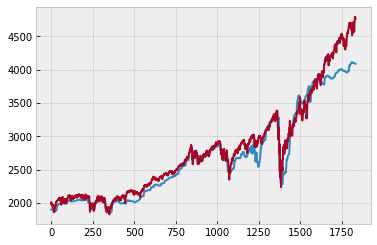

In [65]:
testX = np.hstack((close_lag_test, pe_lag_test, cnn.predict(img_test)))
testX = testX.reshape((testX.shape[0], testX.shape[1], 1))
day1 = model.predict(testX)

In [66]:
lag2 = np.hstack((close_lag_test, day1))
lag2 = lag2[:,1:]
test2 = np.hstack((lag2, pe_lag_test, cnn.predict(img_test)))
test2 = test2.reshape((test2.shape[0], test2.shape[1], 1))
day2 = model.predict(test2)

In [67]:
lag3 = np.hstack((lag2, day2))
lag3 = lag3[:,1:]
test3 = np.hstack((lag3, pe_lag_test, cnn.predict(img_test)))
test3 = test2.reshape((test3.shape[0], test3.shape[1], 1))
day3 = model.predict(test3)

In [68]:
lag4 = np.hstack((lag3, day3))
lag4 = lag4[:,1:]
test4 = np.hstack((lag4, pe_lag_test, cnn.predict(img_test)))
test4 = test2.reshape((test4.shape[0] test4.shape[1], 1))
day4 = model.predict(test4)

In [69]:
day1 = day1*(cmax - cmin) + cmin
day2 = day2*(cmax - cmin) + cmin
day3 = day3*(cmax - cmin) + cmin
day4 = day4*(cmax - cmin) + cmin